# House pricing investigation

In [4]:
# import the packages we need to investigate the data
import numpy as np
import datetime
import matplotlib.pyplot as plt

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
from IPython.display import display, HTML
import warnings
from calendar import monthrange
import matplotlib.dates as mdates
import scipy.stats as st
import requests
from meteostat import Point, Daily
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', False)
seed= 92

In [5]:

# Read the CSV file into a DataFrame
train = pd.read_csv('train.csv')

print(train.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Text(0.5, 1.0, 'kde plot of Sale price of houses')

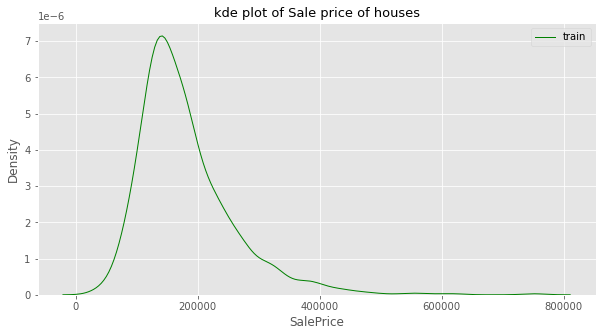

In [6]:
fig = plt.figure(figsize=(10, 5))
ax = sns.kdeplot(data=train, x='SalePrice', color='green', label='train', linewidth= 1)
plt.legend()
ax.set_title('kde plot of Sale price of houses', fontsize=13) 

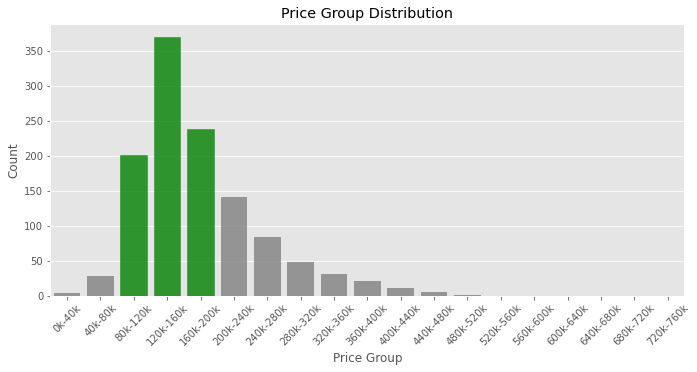

In [54]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(25, 5))
# Create a figure and subplots
ax1 = plt.subplot(1, 2, 1)

bins = list(range(0, 800000, 40000))
labels = [f"{int(start/1000)}k-{int(end/1000)}k" for start, end in zip(bins[:-1], bins[1:])]

# # Define bins and labels
# bins = [0, 40000, 80000, 120000, 160000, 200000, 500000, np.inf]
# labels = ['0-40k', '40k-80k', '80k-120k', '120k-160k', '160k-200k', '200k-500k', '500k+']

# Segment people by age
train['Price Group'] = pd.cut(train['SalePrice'], bins=bins, labels=labels, right=False)
train['Price Group'] = train['Price Group'].astype(str)

# Plot the count of each group
sns.countplot(x='Price Group', data=train, order=labels,color='grey', alpha = 0.8)

# set the color of three highest bars to green 
for i in range(2,5):
    plt.gca().get_children()[i].set_color('g')


ax1.set_xlabel('Price Group')
ax1.set_ylabel('Count')
ax1.set_title('Price Group Distribution')

plt.xticks(rotation=45)  # Rotate x-axis labels if needed

plt.show()




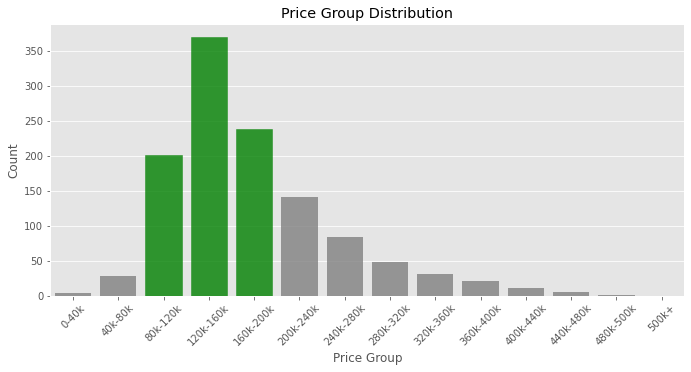

In [57]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(25, 5))
# Create a figure and subplots
ax1 = plt.subplot(1, 2, 1)


# Define bins and labels
bins = [0, 40000, 80000, 120000, 160000, 200000, 240000, 280000, 320000, 360000, 400000, 440000, 480000, 500000, np.inf]
labels = ['0-40k', '40k-80k', '80k-120k', '120k-160k', '160k-200k', '200k-240k', '240k-280k', '280k-320k', '320k-360k', '360k-400k', '400k-440k', '440k-480k', '480k-500k', '500k+']

# Segment people by age
train['Price Group'] = pd.cut(train['SalePrice'], bins=bins, labels=labels, right=False)
train['Price Group'] = train['Price Group'].astype(str)

# Plot the count of each group
sns.countplot(x='Price Group', data=train, order=labels,color='grey', alpha = 0.8)

# set the color of three highest bars to green 
for i in range(2,5):
    plt.gca().get_children()[i].set_color('g')


ax1.set_xlabel('Price Group')
ax1.set_ylabel('Count')
ax1.set_title('Price Group Distribution')

plt.xticks(rotation=45)  # Rotate x-axis labels if needed

plt.show()


In [8]:
# cst = create_scrollable_table
def cst(df, table_id, title): 
    html = f'<style>'
    html += f'#{table_id} {{height:200px; overflow:auto;}}'
    html += f'#{table_id} thead tr {{position:sticky; top:0;}}'
    html += f'#{table_id} thead th {{background-color: white;}}'
    html += '</style>'
    html += f'<h3>{title}</h3>'
    html += f'<div id="{table_id}">'
    html += df.to_html()
    html += '</div>'
    display(HTML(html))
    display(df.shape)

In [9]:
# Statistics also transpose for easier readability
summary_stat_numeric = train.describe(include=[
    'int64','float64']).round(2).T

cst(summary_stat_numeric, 
             'summary_stat_numeric', 
             'Summary Statistics of numerical columns')



,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.50,421.61,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.90,42.30,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.05,24.28,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.83,9981.26,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.10,1.38,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.58,1.11,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.27,30.20,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.87,20.65,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.69,181.07,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.64,456.10,0.0,0.00,383.5,712.25,5644.0


(38, 8)

In [10]:

summary_stat_categorical = train.describe(include=[
    'object']).round().T

cst(summary_stat_categorical, 
        "summary_stat_categorical",
        "Summary Statistics of categorical columns")

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


(44, 4)

In [11]:
# remove outliers
train = train[train['SalePrice'] < 500000]
train.info()
# We can see that some prices are outliers that can be removed to improve the accuracy of our data analysis.
# Prices over 500000 can be removed.
# TODO group the outliers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1451 non-null   int64  
 1   MSSubClass     1451 non-null   int64  
 2   MSZoning       1451 non-null   object 
 3   LotFrontage    1192 non-null   float64
 4   LotArea        1451 non-null   int64  
 5   Street         1451 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1451 non-null   object 
 8   LandContour    1451 non-null   object 
 9   Utilities      1451 non-null   object 
 10  LotConfig      1451 non-null   object 
 11  LandSlope      1451 non-null   object 
 12  Neighborhood   1451 non-null   object 
 13  Condition1     1451 non-null   object 
 14  Condition2     1451 non-null   object 
 15  BldgType       1451 non-null   object 
 16  HouseStyle     1451 non-null   object 
 17  OverallQual    1451 non-null   int64  
 18  OverallC

In [ ]:

# Select only the numerical columns
numerical_data = train.select_dtypes(include=['int64', 'float64'])

# Select columns for the dependent variable and independent variables
dependent_var = numerical_data['SalePrice']
independent_vars = numerical_data.drop('SalePrice', axis=1)

# Calculate the number of subplots needed
num_subplots = len(independent_vars.columns)

# Create subplots
fig, axes = plt.subplots(num_subplots, 1, figsize=(8, num_subplots*4))

# Iterate over the independent variables and create scatter plots
for i, column in enumerate(independent_vars.columns):
    ax = axes[i]
    ax.scatter(independent_vars[column], dependent_var)
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Prices')

# Adjust the layout and spacing between subplots
plt.tight_layout()

# TODO features correlation 的包


# Multi-linear regression of prices and numerical data


In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Exclude rows with missing values from 'train' DataFrame

train = train[(train['LotFrontage'] < 200) & (train['LotArea'] < 50000)]
# Log transformation of 'SalePrice'
train['LogSalePrice'] = np.log(train['SalePrice'])

# rename 
train.rename(columns={'1stFlrSF': 'FirstFlrSF'}, inplace=True)
train.rename(columns={'2ndFlrSF': 'SecondFlrSF'}, inplace=True)


# Specify the formula with the log-transformed variable
formula = 'LogSalePrice ~ LotArea + LotFrontage + YearBuilt + YearRemodAdd + MasVnrArea + BsmtUnfSF + TotalBsmtSF + FirstFlrSF + SecondFlrSF + GarageYrBlt + GarageArea + WoodDeckSF + OpenPorchSF'
lm = smf.ols(formula=formula, data=train).fit()
lm.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           LogSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     368.6
Date:                Mon, 29 Jan 2024   Prob (F-statistic):               0.00
Time:                        12:49:28   Log-Likelihood:                 431.44
No. Observations:                1107   AIC:                            -834.9
Df Residuals:                    1093   BIC:                            -764.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.1519      0.594     -3.624      0.000      -3.317      -0.987
LotArea       3.405e-06   1.49e-06      2.286      0.022    4.82e-07    6.33e-06
LotFrontage      0.0010      0.000      3.348      0.001       0.000       0.002
YearBuilt        0.0026      0.000      8.596      0.000       0.002       0.003
YearRemodAdd     0.0041      0.000     12.647      0.000       0.003       0.005
MasVnrArea    4.323e-05    3.2e-05      1.351      0.177   -1.96e-05       0.000
BsmtUnfSF    -8.649e-05   1.27e-05     -6.786      0.000      -0.000   -6.15e-05
TotalBsmtSF      0.0003    2.4e-05     11.426      0.000       0.000       0.000
FirstFlrSF       0.0003    2.6e-05     11.137      0.000       0.000       0.000
SecondFlrSF      0.0003   1.41e-05     23.846      0.000       0.000       0.000
GarageYrBlt  -3.743e-05      0.000     -0.094      0.925      -0.001       0.001
GarageArea       0.0002   3.96e-05      4.438      0.000     9.8e-05       0.000
WoodDeckSF       0.0001   4.53e-05      2.230      0.026    1.21e-05       0.000
OpenPorchSF      0.0001   8.56e-05      1.740      0.082    -1.9e-05       0.000
==============================================================================
Omnibus:                      638.789   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19208.208
Skew:                          -2.100   Prob(JB):                         0.00
Kurtosis:                      22.970   Cond. No.                     1.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> Modify the model based on the initial model analysis.

> Modify the model to make AIC and BIC lower, and remove those variables with too large p-value.

In [14]:
# Specify the formula with the log-transformed variable
formula = 'LogSalePrice ~ LotArea + LotFrontage + YearBuilt + YearRemodAdd + BsmtUnfSF + TotalBsmtSF + FirstFlrSF + SecondFlrSF + GarageArea'
lm = smf.ols(formula=formula, data=train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           LogSalePrice   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     599.6
Date:                Mon, 29 Jan 2024   Prob (F-statistic):               0.00
Time:                        12:49:28   Log-Likelihood:                 422.34
No. Observations:                1187   AIC:                            -824.7
Df Residuals:                    1177   BIC:                            -773.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.1365      0.527     -4.050      0.000      -3.171      -1.102
LotArea       4.226e-06   1.49e-06      2.832      0.005     1.3e-06    7.15e-06
LotFrontage      0.0006      0.000      2.210      0.027    7.11e-05       0.001
YearBuilt        0.0027      0.000     12.708      0.000       0.002       0.003
YearRemodAdd     0.0039      0.000     13.147      0.000       0.003       0.005
BsmtUnfSF    -9.688e-05   1.26e-05     -7.671      0.000      -0.000   -7.21e-05
TotalBsmtSF      0.0003    2.3e-05     12.419      0.000       0.000       0.000
FirstFlrSF       0.0003   2.53e-05     11.867      0.000       0.000       0.000
SecondFlrSF      0.0004   1.31e-05     26.713      0.000       0.000       0.000
GarageArea       0.0003   3.02e-05      9.252      0.000       0.000       0.000
==============================================================================
Omnibus:                      646.101   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14981.876
Skew:                          -2.020   Prob(JB):                         0.00
Kurtosis:                      19.929   Cond. No.                     1.16e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Noticing there is strong multicollinearity problems, here I plotted a scatter matrix plot to identify the culticolinearity.

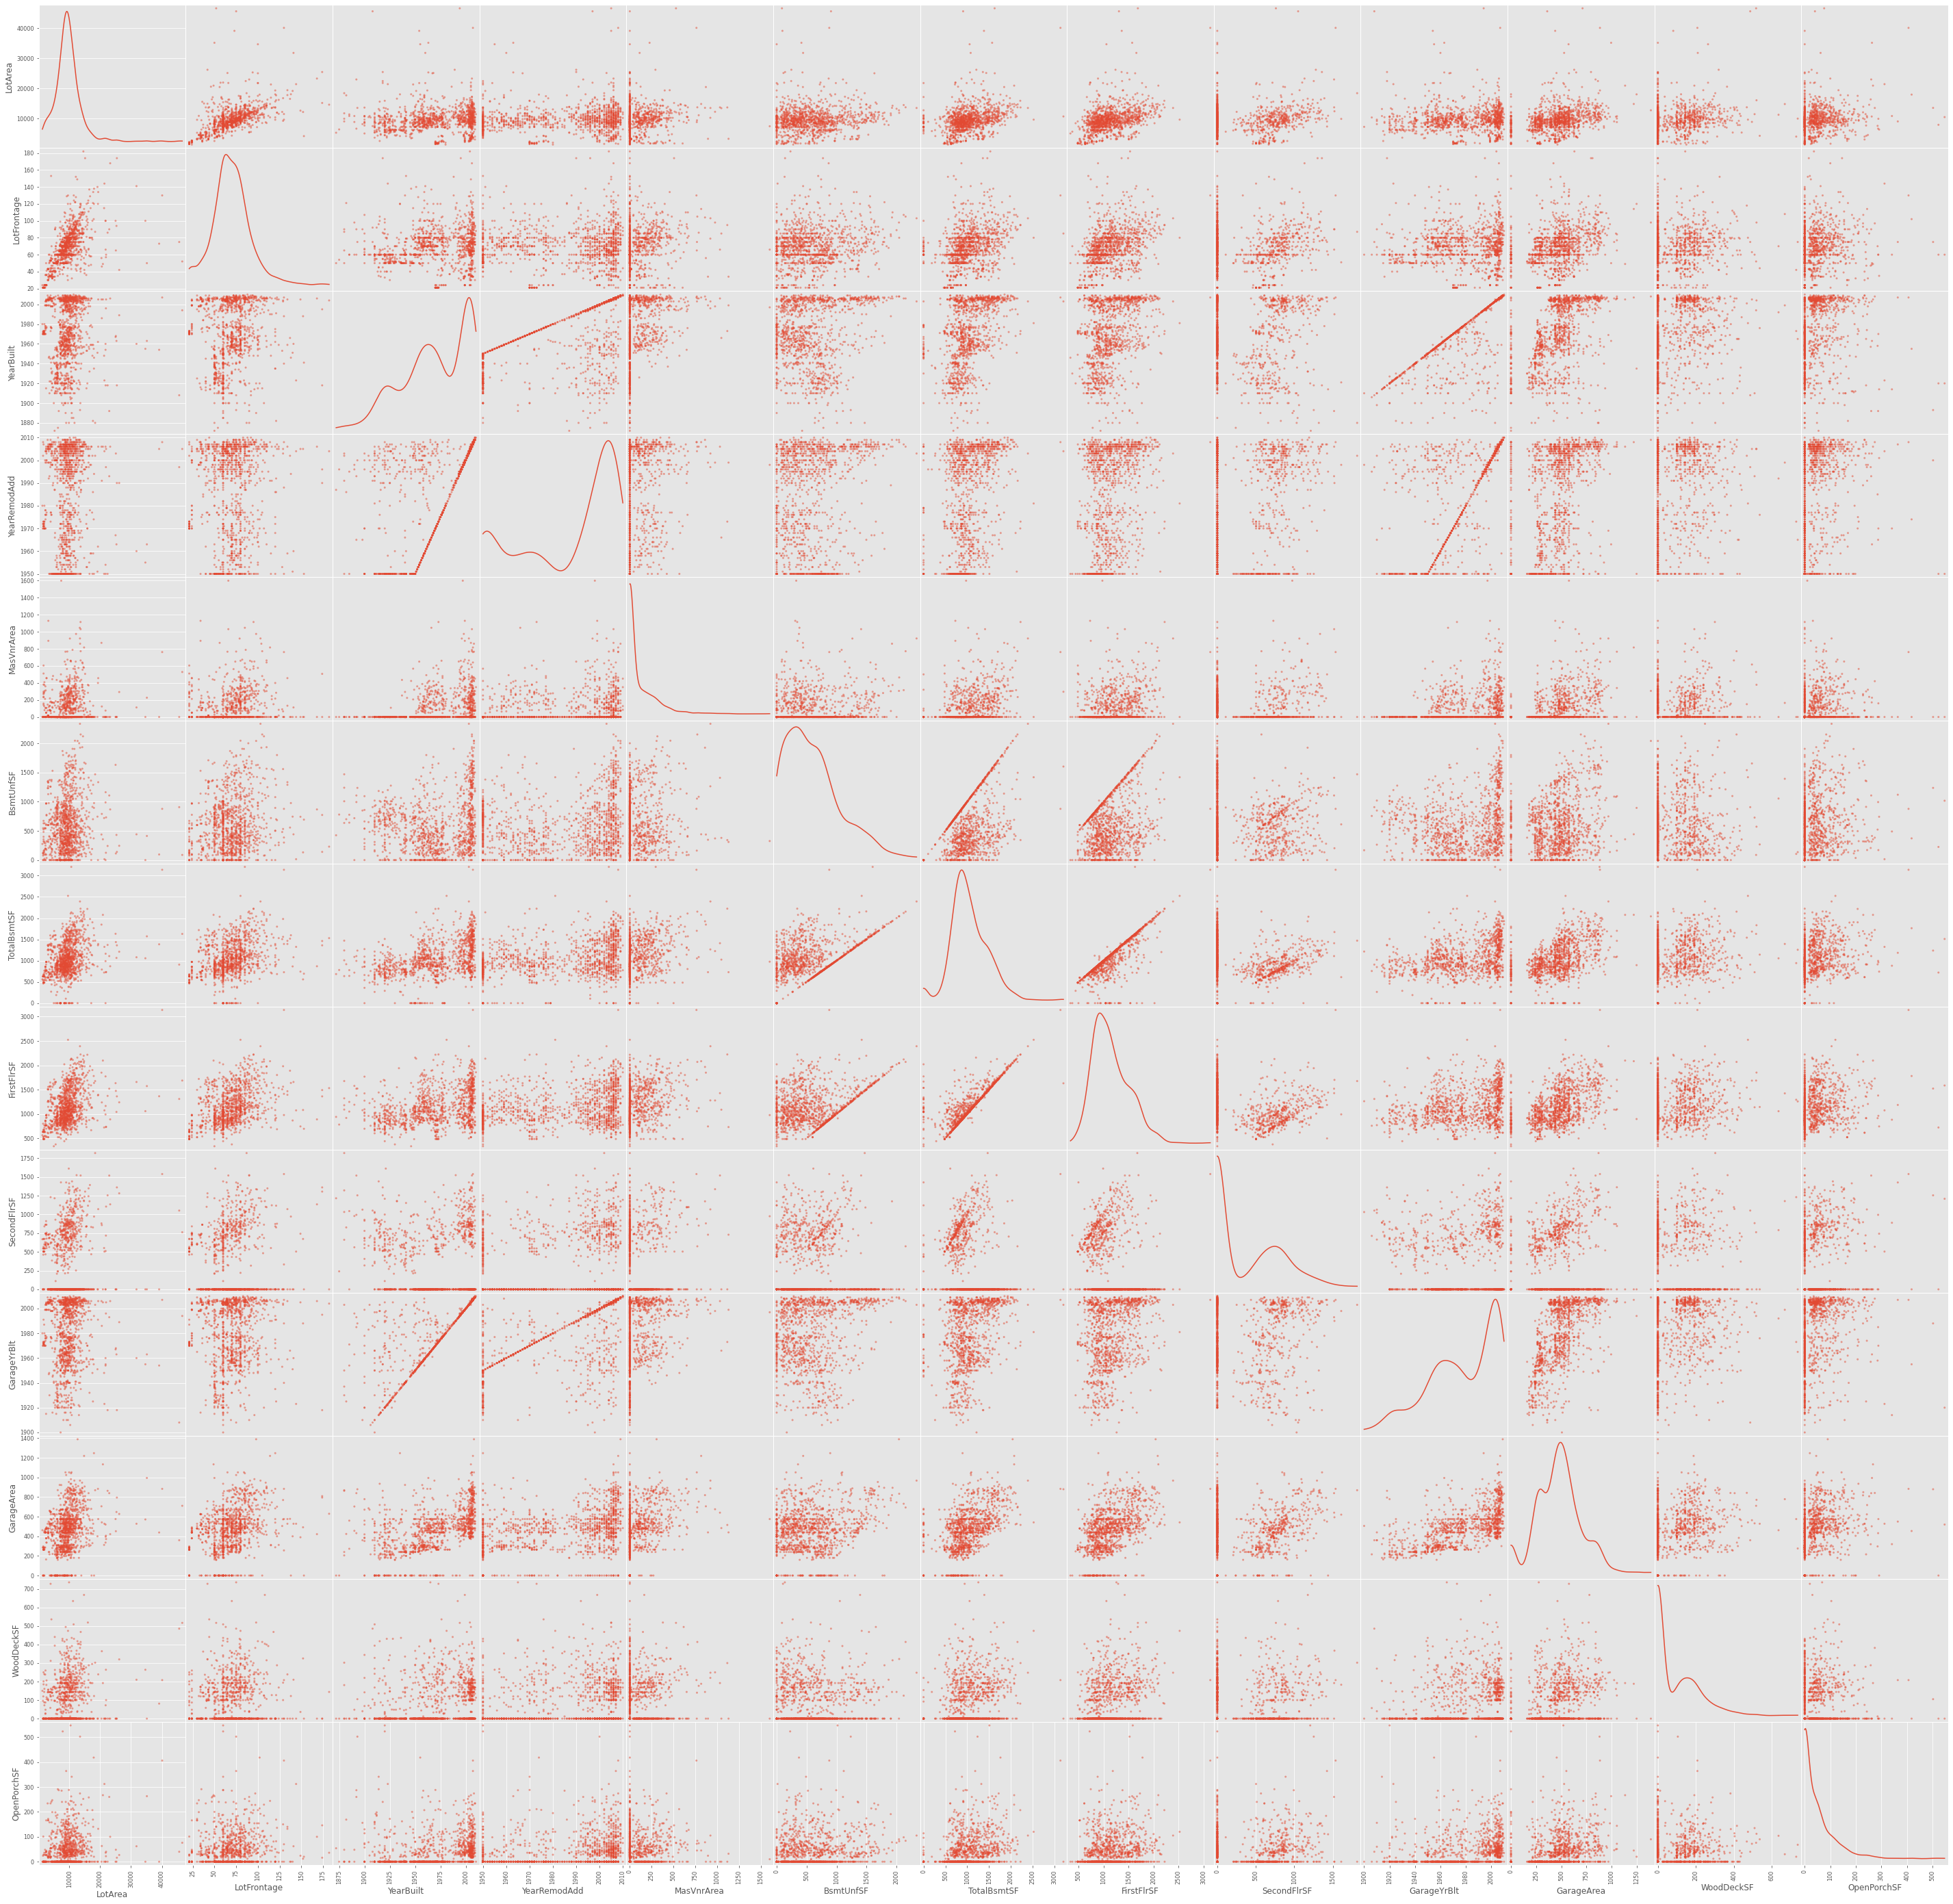

In [15]:
selected_columns = ['LotArea','LotFrontage','YearBuilt', 'YearRemodAdd','MasVnrArea','BsmtUnfSF','TotalBsmtSF','FirstFlrSF','SecondFlrSF','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF']
train[selected_columns] = train[selected_columns].astype(float)

scatter_matrix(train[selected_columns], figsize=(50, 50), diagonal='kde')
plt.show()

`YearBuilt` ~ `GarageYrBlt` ~ `YearRemodAdd`

`BsmtUnfSF` ~ `TotalBsmtSF` ~ `FirstFlrSF`

These factors are highly correlated


## Alley type impact on house price

<class 'pandas.core.series.Series'>
Int64Index: 1187 entries, 0 to 1459
Series name: Alley
Non-Null Count  Dtype 
--------------  ----- 
1187 non-null   object
dtypes: object(1)
memory usage: 18.5+ KB


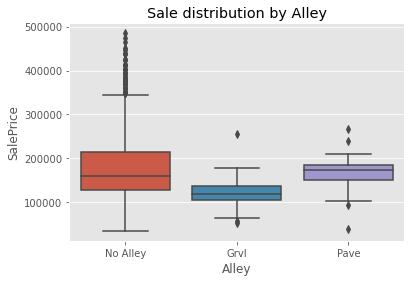

In [16]:
train['Alley'].fillna('No Alley', inplace=True)
train['Alley'].info()

sns.boxplot(x='Alley', y='SalePrice', data=train)
plt.title('Sale distribution by Alley')
plt.show()

In [17]:
# price of houses with gravel road alley
train[train['Alley']=='Grvl']['SalePrice'].mean()



122243.70212765958

In [18]:
# price of houses with pave road alley
train[train['Alley']=='Pave']['SalePrice'].mean()


167398.05128205128

In [19]:
train[train['Alley']=='No Alley']['SalePrice'].mean()

179762.36239782016

It can be concluded that the prices of houses with Gravel road alleys are significantly lower than paved houses or no alley houses

## Year sold impact on House price

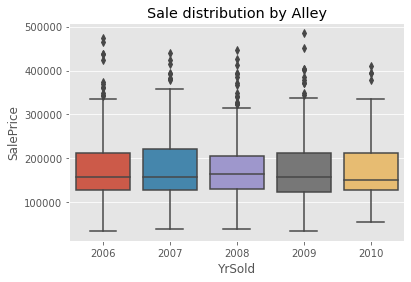

In [20]:
sns.boxplot(x='YrSold', y='SalePrice', data=train[train['SalePrice']< 500000])
plt.title('Sale distribution by Alley')
plt.show()

We can see that the year when the house was sold has little impact on house prices.

## Sale type impact on house price

> Types are:

       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

In [21]:
train['SaleType'].value_counts()

WD       1013
New       116
COD        32
ConLD       8
ConLw       5
ConLI       4
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

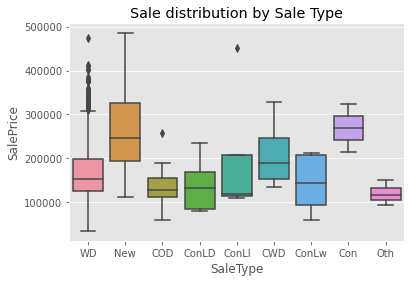

In [22]:

sns.boxplot(x='SaleType', y='SalePrice', data=train[train['SalePrice']< 500000])
plt.title('Sale distribution by Sale Type')
plt.show()

From the boxplot above, we could conclude that the sale type has relatively sinificant impact on prices.

Specifically, New houses and Court Officer Deed/Estate can be sold at higher prices.


## Type of dwelling impact on prices


In [23]:
train['MSSubClass'].value_counts()

20     430
60     223
50     128
120     67
30      63
70      55
160     55
90      47
80      38
190     27
75      15
85      14
45      12
180     10
40       3
Name: MSSubClass, dtype: int64

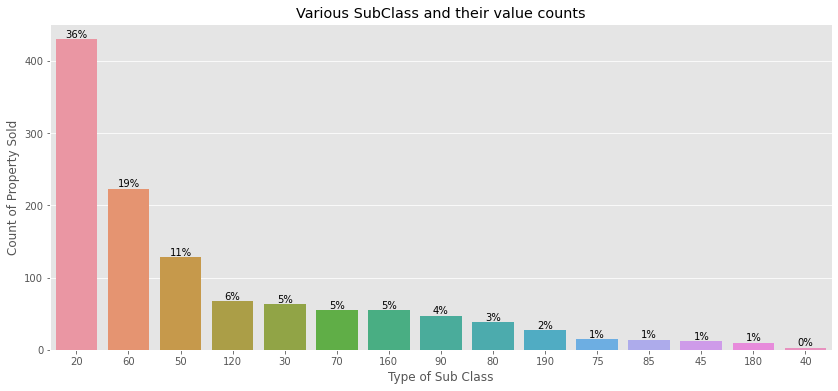

In [24]:
plt.figure(figsize=(14,6))

# Calculate the count of each category
category_counts = train['MSSubClass'].value_counts()

# Sort the categories based on their counts in descending order
sorted_categories = category_counts.sort_values(ascending=False).index

# Plot the countplot with the sorted categories
ax = sns.countplot(data=train, x='MSSubClass', order=sorted_categories)
plt.xlabel("Type of Sub Class")
plt.ylabel("Count of Property Sold")
plt.title("Various SubClass and their value counts")

# Adding annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()/len(train)*100:,.0f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

Houses that are 1-STORY 1946 & NEWER ALL STYLES make up 37% of all houses.

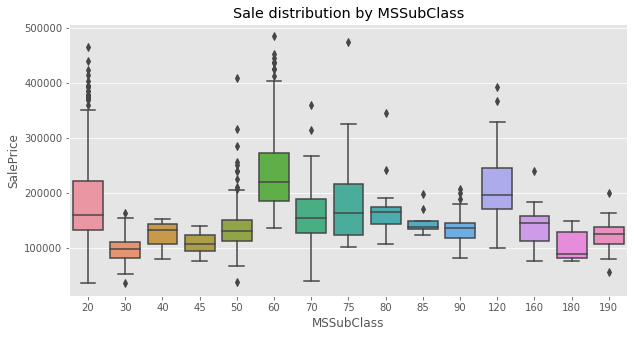

In [25]:
fig = plt.figure(figsize=(10, 5))
sns.boxplot(x='MSSubClass', y='SalePrice', data=train[train['SalePrice']< 500000])
plt.title('Sale distribution by MSSubClass')
plt.show()

## Street impact on sales


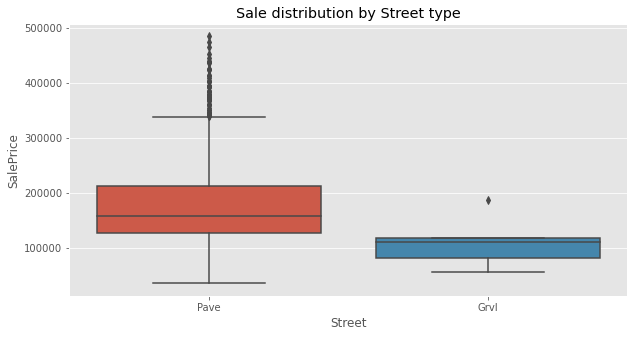

In [26]:
fig = plt.figure(figsize=(10, 5))
sns.boxplot(x='Street', y='SalePrice', data=train[train['SalePrice']< 500000])
plt.title('Sale distribution by Street type')
plt.show()

Houses with pave can be sold at higher price.

## `OverallQual` impact on price

OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor


In [27]:
import pandas as pd 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt